In [2]:
from model import FlashModel
from train import *
import pickle
import torch

with open('models/model_p2.mdl', 'rb') as model_file:
    model = pickle.load(model_file)

model.eval()

FlashModel(
  (network): Sequential(
    (Conv1): Conv2d(4, 16, kernel_size=(1, 55), stride=(1, 1))
    (Conv2): Conv2d(16, 32, kernel_size=(5, 1), stride=(1, 1))
    (ReLU1): ReLU()
    (MaxPool1): MaxPool2d(kernel_size=(2, 1), stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv3): Conv2d(32, 64, kernel_size=(5, 1), stride=(1, 1))
    (ReLU2): ReLU()
    (MaxPool2): MaxPool2d(kernel_size=(2, 1), stride=2, padding=0, dilation=1, ceil_mode=False)
    (Flatten): Flatten(start_dim=1, end_dim=-1)
    (Dropout): Dropout(p=0.2, inplace=False)
    (FC1): Linear(in_features=1408, out_features=512, bias=True)
    (ReLU3): ReLU()
    (FC2): Linear(in_features=512, out_features=128, bias=True)
    (ReLU4): ReLU()
    (FC3): Linear(in_features=128, out_features=24, bias=True)
  )
)

In [3]:
import numpy as np

def tensor_idx(variable_name, station_idx):
    match variable_name:
        case 'PRCP':
            return 6*station_idx
        case 'TMAX':
            return 6*station_idx+1
        case 'TMIN':
            return 6*station_idx+2
        case 'AWND':
            return 6*station_idx+3
        case 'UWSF12':
            return 6*station_idx+4
        case 'VWSF12':
            return 6*station_idx+5

def derived_idx(variable_name, station_idx):
    match variable_name:
        case 'WSF12':
            return 7*station_idx
        case 'WDF12':
            return 7*station_idx+1
        case 'UWDF12':
            return 7*station_idx+2
        case 'VWDF12':
            return 7*station_idx+3
        case 'TAVG':
            return 7*station_idx+4
        case 'TSPREAD':
            return 7*station_idx+5
        case 'WSPREAD':
            return 7*station_idx+6

def display_forecast(forecast_tensor, forecast_date, station_idx):
    PRCP = float(forecast_tensor[tensor_idx('PRCP', station_idx)])
    TMAX = float(forecast_tensor[tensor_idx('TMAX', station_idx)])
    TMIN = float(forecast_tensor[tensor_idx('TMIN', station_idx)])
    AWND = float(forecast_tensor[tensor_idx('AWND', station_idx)])
    UWSF12 = float(forecast_tensor[tensor_idx('UWSF12', station_idx)])
    VWSF12 = float(forecast_tensor[tensor_idx('VWSF12', station_idx)])
    
    print('======================================')
    print(f'Forecast for {forecast_date} at station {station_idx}:')
    print(f'Expected precipitation: {PRCP} hundredths in.')
    print(f'High temperature: {TMAX} deg F')
    print(f'Low temperature: {TMIN} deg F')
    print(f'Average wind speed: {AWND} mph')
    print(f'Eastward wind gust speed: {UWSF12} mph')
    print(f'Northward wind gust speed: {VWSF12} mph')
    print('======================================')

def normal_clamp_forecast(forecast_tensor, normals, num_stations):
    clamp = lambda x, min_val, max_val: min(max_val, max(x, min_val))
    clamped_forecast = torch.zeros_like(forecast_tensor)
    
    for station_idx in range(num_stations):
        PRCP = float(forecast_tensor[tensor_idx('PRCP', station_idx)])
        TMAX = float(forecast_tensor[tensor_idx('TMAX', station_idx)])
        TMIN = float(forecast_tensor[tensor_idx('TMIN', station_idx)])
        AWND = float(forecast_tensor[tensor_idx('AWND', station_idx)])
        UWSF12 = float(forecast_tensor[tensor_idx('UWSF12', station_idx)])
        VWSF12 = float(forecast_tensor[tensor_idx('VWSF12', station_idx)])

        PRCP_normal = float(normals[tensor_idx('PRCP', station_idx)])
        TMAX_normal = float(normals[tensor_idx('TMAX', station_idx)])
        TMIN_normal = float(normals[tensor_idx('TMIN', station_idx)])
        AWND_normal = float(normals[tensor_idx('AWND', station_idx)])
        UWSF12_normal = float(normals[tensor_idx('UWSF12', station_idx)])
        VWSF12_normal = float(normals[tensor_idx('VWSF12', station_idx)])

        PRCP = clamp(PRCP, 0, 100 * PRCP_normal)
        TMAX = clamp(TMAX, TMIN + 1, 2 * abs(TMAX_normal))
        TMIN = clamp(TMIN, -2 * abs(TMIN_normal), TMAX - 1)
        AWND = clamp(AWND, 0, 4 * AWND_normal)
        UWSF12 = clamp(UWSF12, -4 * abs(UWSF12), 4 * abs(UWSF12))
        VWSF12 = clamp(VWSF12, -4 * abs(VWSF12), 4 * abs(VWSF12))

        clamped_forecast[tensor_idx('PRCP', station_idx)] = PRCP
        clamped_forecast[tensor_idx('TMAX', station_idx)] = TMAX
        clamped_forecast[tensor_idx('TMIN', station_idx)] = TMIN
        clamped_forecast[tensor_idx('AWND', station_idx)] = AWND
        clamped_forecast[tensor_idx('UWSF12', station_idx)] = UWSF12
        clamped_forecast[tensor_idx('VWSF12', station_idx)] = VWSF12

    return clamped_forecast

def create_derived_values_from_forecast(forecast_tensor, forecast_date, num_stations, out_features):
    derived_tensor = torch.zeros(out_features - forecast_tensor.size()[0] - 3)

    for station_idx in range(num_stations):
        PRCP = float(forecast_tensor[tensor_idx('PRCP', station_idx)])
        TMAX = float(forecast_tensor[tensor_idx('TMAX', station_idx)])
        TMIN = float(forecast_tensor[tensor_idx('TMIN', station_idx)])
        AWND = float(forecast_tensor[tensor_idx('AWND', station_idx)])
        UWSF12 = float(forecast_tensor[tensor_idx('UWSF12', station_idx)])
        VWSF12 = float(forecast_tensor[tensor_idx('VWSF12', station_idx)])

        WDF12 = np.arctan(VWSF12 / UWSF12)
        WSF12 = UWSF12 / np.cos(WDF12)
        UWDF12 = np.cos(WDF12) * np.cos(WDF12)
        VWDF12 = np.sin(WDF12) * np.sin(WDF12)
        TAVG = (TMAX + TMIN) / 2
        TSPREAD = TMAX - TMIN
        WSPREAD = WSF12 - AWND

        derived_tensor[derived_idx('WDF12', station_idx)] = WDF12
        derived_tensor[derived_idx('WSF12', station_idx)] = WSF12
        derived_tensor[derived_idx('UWDF12', station_idx)] = UWDF12
        derived_tensor[derived_idx('VWDF12', station_idx)] = VWDF12
        derived_tensor[derived_idx('TAVG', station_idx)] = TAVG
        derived_tensor[derived_idx('TSPREAD', station_idx)] = TSPREAD
        derived_tensor[derived_idx('WSPREAD', station_idx)] = WSPREAD
    
    DAY365 = pd.to_datetime(forecast_date).day_of_year / 365.25
    SIN = np.sin(2 * np.pi * DAY365)
    COS = np.cos(2 * np.pi * DAY365)
    
    time_tensor = torch.tensor((DAY365, SIN, COS))
    return torch.concat((forecast_tensor, derived_tensor, time_tensor), dim=0)

def fetch_normals_for_date(normals, forecast_date):
    mean_columns = [x for x in normals.columns if 'mean' in x]
    day = forecast_date.day_of_year
    day = day if day < 366 else 1
    means = normals[mean_columns].loc[day]
    return torch.from_numpy(means.values)
    

In [4]:
def create_forecast(model, historical, normals, forecast_start, forecast_length):
    t, dl = create_tensors(historical, normals)
    
    forecast_start_idx = dl[forecast_start]
    historical_data_start = forecast_start_idx - model.sequence_length
    historical_data_end = forecast_start_idx - 1
    
    current_lookback = get_many_historical_features(historical_data_start, historical_data_end, t.float(), dl, model.output_features, input=True)
    #print(current_lookback.size())
    
    forecast = []

    start_date = pd.to_datetime(forecast_start)
    for i in range(forecast_length):
        current_date = start_date + pd.Timedelta(days=i)
        prediction = model(current_lookback.unsqueeze(0))[0]
        
        daily_means = fetch_normals_for_date(normals, current_date)
        clamped_prediction = normal_clamp_forecast(prediction, daily_means, model.stations)
        forecast.append(clamped_prediction)
        
        #display_forecast(clamped_prediction, current_date, 0)

        extended_prediction = create_derived_values_from_forecast(clamped_prediction, current_date, model.stations, current_lookback.size()[2])
        difference = extended_prediction - daily_means
        squared = difference * difference

        features = torch.stack((extended_prediction.unsqueeze(0), 
                                daily_means.unsqueeze(0), 
                                difference.unsqueeze(0), 
                                squared.unsqueeze(0)), dim=0)

        #print(features.size())

        current_lookback = torch.concat((current_lookback[:, 1:], features.float()), dim=1)

    return torch.stack(forecast, dim=0)

    

In [5]:
def get_forecasted_period_from_historical(model, historical, normals, forecast_start, forecast_length):
    t, dl = create_tensors(historical, normals)
    
    forecast_start_idx = dl[forecast_start]
    forecast_end_idx = forecast_start_idx + forecast_length - 1

    actual_features = get_many_historical_features(forecast_start_idx, forecast_end_idx, t.float(), dl, model.output_features, input=False)
    
    return actual_features


In [6]:
historical_data = r"data\multidata2.csv"
normals_data = r"data\multinormals2.csv"

historical = pd.read_csv(historical_data)
normals = pd.read_csv(normals_data)
normals.index = normals['DAY'].values

weeks = 64
start_date = '2012-01-01'

days = 7 * weeks
forecast = create_forecast(model, historical, normals, start_date, days)
actual_observations = get_forecasted_period_from_historical(model, historical, normals, start_date, days)

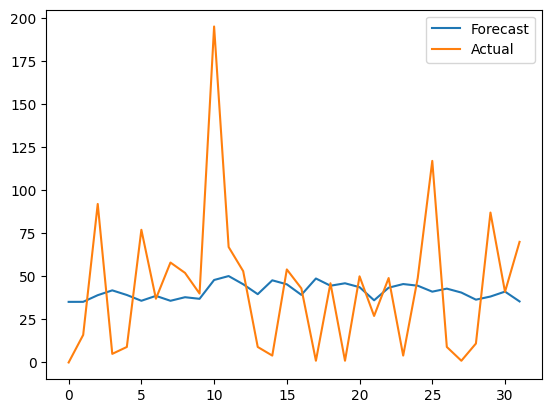

In [15]:
import matplotlib.pyplot as plt

station = 0
buckets = 32

forecasted_rain = forecast[:, station].detach().numpy()
actual_rain = actual_observations[:, station].detach().numpy()

forecasted_weekly_totals = np.zeros(weeks)
actual_weekly_totals = np.zeros(weeks)
for i in range(days):
    week = i // 7
    forecasted_weekly_totals[week] += forecasted_rain[i]
    actual_weekly_totals[week] += actual_rain[i]

forecasted_totals = np.sum(forecasted_weekly_totals.reshape(-1, weeks//buckets), axis=1)
actual_totals = np.sum(actual_weekly_totals.reshape(-1, weeks//buckets), axis=1)

plt.plot(range(buckets), forecasted_totals, label='Forecast')
plt.plot(range(buckets), actual_totals, label='Actual')
plt.legend()
plt.show()